Set whatever number of detectors you want to make a skymap for to be true, and then run the code, a skymap will be generated... solved for optimal tilt geometries in othe programs, so these are already set at that. 

In [1]:
%matplotlib notebook

import time
import numpy as np
import matplotlib.pyplot as plt
import math as mth
import random as rand
import statistics as s
import healpy as hp
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap
from matplotlib import cm, colors
from healpy import newvisufunc

In [2]:
#Detector Numbers

three=False
four=False
five=False
six=True
eight=False
twelve=False

In [3]:
def length(v):
    return mth.sqrt(np.dot(v, v))

def angle(v1, v2):

    return mth.acos(np.dot(v1, v2) / (length(v1) * length(v2)))

def response(A,B):
    #meant to imitate the response of the detectors for effective area vs. angle, found to be around .76
    return pow(abs(np.cos(angle(A,B))),0.76)


def chimaker(chiterms,Ndets): 
    #separate out all of the individual chi squared terms, and add each together. 
    if three==True:
        a,b,c=np.array_split(chiterms,Ndets)
        ab=np.add(a,b)
        chisquareds=(np.add(ab,c)) 
    if four==True:
        a,b,c,d=np.array_split(chiterms,Ndets)
        ab=np.add(a,b)
        cd=np.add(c,d)
        chisquareds=(np.add(ab,cd)) 
    if five==True:
        a,b,c,d,e=np.array_split(chiterms,Ndets)
        ab=np.add(a,b)
        cd=np.add(c,d)
        ad=np.add(ab,cd)
        chisquareds=(np.add(ad,e)) 
    if six==True:
        a,b,c,d,e,f=np.array_split(chiterms,Ndets)
        ab=np.add(a,b)
        cd=np.add(c,d)
        ad=np.add(ab,cd)
        ae=np.add(ad,e)
        chisquareds=(np.add(ae,f))
    if eight==True:
        a,b,c,d,e,f,g,h=np.array_split(chiterms,Ndets)
        ab=np.add(a,b)
        cd=np.add(c,d)
        ef=np.add(e,f)
        gh=np.add(g,h)
        ad=np.add(ab,cd)
        eh=np.add(ef,gh)
        ah=np.add(ad,eh)
        chisquareds=ah
    if twelve==True:
        a,b,c,d,e,f,g,h,i,j,k,l=np.array_split(chiterms,Ndets)
        ab=np.add(a,b)
        cd=np.add(c,d)
        ef=np.add(e,f)
        gh=np.add(g,h)
        ij=np.add(i,j)
        kl=np.add(k,l)   
        ad=np.add(ab,cd)
        eh=np.add(ef,gh)
        il=np.add(ij,kl)
        ah=np.add(ad,eh)
        al=np.add(ah,il)
        chisquareds=al
    return chisquareds

def solver(detsvals,bottheta,toptheta,botphi,topphi,n):
#this function uses a chi squared minimizer over a given range to identify the theta,phi,
#and Ao values which correspond to the minimum chi squared and thus localized source. 
    confidence = []
    chiterms = []
    thecon = []
    phicon = []
    for s in range(len(detsvals)):     
        oa=np.deg2rad(np.linspace(bottheta,toptheta,n))  #range of thetas to sample
        ob=np.deg2rad(np.linspace(botphi,topphi,n)) #phi
        Aofit=np.linspace(0,1000,25)  
        for sa in range(len(oa)): 
            for sb in range(len(ob)):
                for sc in range(len(Aofit)):
                    #make sure it fits within the acceptable range
                    if oa[sa]>=0 and oa[sa]<=np.pi and ob[sb]>=0 and ob[sb]<=2*np.pi:
                        CHIsourceang=[oa[sa],ob[sb]]
                        CHIsourcexyz = hp.ang2vec(CHIsourceang[0],CHIsourceang[1])
                        CHIsep=angle(CHIsourcexyz,dets[s])                                           
                        if CHIsep<np.pi: 
                            chi=Aofit[sc]*response(CHIsourcexyz,dets[s])+bg
                            #print("Chi test angle"+str(CHIsourcexyz))
                            #print("detector"+str(dets[s]))
                            #print("chi sometiems"+str(chi))
                            #print("separation here, is it okay? " +str(np.rad2deg(CHIsep)))

                            #this produces nan error, se
                            
                        else:
                            chi=0            
                        if detvals[s]>0:   #if there is a signal in the detector 
                            chiterm=((chi-detsvals[s])**2/detsvals[s])
                        else:    #if not, just zero 
                            chiterm=10000
                    else: 
                        chiterm=10000 #some large #, just to note that it definitely isn't right angle 
                                                                       
                                    
                    chiterms.append(chiterm)   #this is an array of EVERY SINGLE term, need to split in pieces and add element by element...
    chisquareds=chimaker(chiterms,len(detsvals))
    chimin=np.amin(chisquareds)
    chisquareds=list(chisquareds)
    thetaloc = np.rad2deg(oa[int((chisquareds.index(chimin)-(chisquareds.index(chimin) % (len(ob)*len(Aofit))))/(len(ob)*len(Aofit)))])
    philoc = np.rad2deg(ob[int(((chisquareds.index(chimin) % (len(ob)*len(Aofit)))-(chisquareds.index(chimin) % (len(Aofit))))/len(Aofit))])
    Aoguess=Aofit[int((chisquareds.index(chimin) % (len(ob)*len(Aofit)))  % len(Aofit))]
    #print(Aoguess)
    #print(thetaloc,philoc)
    
    return thetaloc,philoc,chisquareds,chimin,Aoguess


def rotate(x,y,theta):
    #inpute the x and y (or what components to be rotated) of the normal, and transform them by angle theta, provided in code.
    xnew=np.cos(theta)*x-np.sin(theta)*y
    ynew=np.sin(theta)*x+np.cos(theta)*y
    rotnorm=[xnew/((xnew*xnew+ynew*ynew)**.5),ynew/((xnew*xnew+ynew*ynew)**.5)]
    return rotnorm

In [4]:
start_time = time.time()

zenith=[0,0]  #set zenith of the system

#Test detector orientations(letters B,C,E,etc. are at same but oppiste side angles)

#These are all the optimal tilts for the detectors already solved, could easily add more if wanted.. 
if three==True:
    tiltA=np.deg2rad(np.array([15]))    #3 detectors
if four==True:    
    tiltA=np.deg2rad(np.array([30]))    #4 detectors
if five==True:
    tiltA=np.deg2rad(np.array([45]))    #5 detectors
if six==True:
    tiltA=np.deg2rad(np.array([30]))    #6 detectors
if eight==True:
    tiltA=np.deg2rad(np.array([30]))    #8 detectors
if twelve==True:
    tiltA=np.deg2rad(np.array([45]))

tiltD1=np.deg2rad(np.array([30]))  

if four==True:
    tiltD1=np.deg2rad(np.array([45]))   
if six==True:
    tiltD1=np.deg2rad(np.array([45]))  
if eight==True: 
    tiltD1=np.deg2rad(np.array([35]))   

if twelve==True:
    tiltD1=np.deg2rad(np.array([30]))    #linspace(30,75,4)



#Test source locations


#plt.figure(figsize=(20,10))


Ao=np.array([500]) #intensity of the signal, can loop through more! 
bg=1000   #background noise in each detector
error=[]
x = 100  #run x times per source location
delta=5  #pinpointing for coarse-fine localization
chimins = []   #create a list of every minimized chisquared
RMSs = []
NSIDE=8
pixels=hp.nside2npix(NSIDE)
print("looping this many pixels: " + str(pixels))
for ja in range(len(tiltA)):   #run through the possible detector orientations
    tiltB=tiltA[ja]
    if three==True:
                  
        tiltC=tiltA[ja]
    if four==True:
        tiltB=tiltA[ja]

    if five==True:
      
        tiltC=tiltB
        tiltD=tiltB
        tiltE=tiltB
    if six==True:
        tiltE=tiltC=tiltA[ja]

    
    if eight==True:
        tiltG=tiltE=tiltC=tiltA[ja]
####################################################
    if twelve==True: 
        tiltK=tiltI=tiltG=tiltE=tiltC=tiltA[ja]
#####################################################
    for jb in range(len(tiltD1)): 
        print("Detector Tilt " + str(np.rad2deg(tiltA[ja]))+ " degrees x " +str(np.rad2deg(tiltD1[jb]))+ " degrees")
        if four==True:
            tiltE=tiltD1[jb]
        if twelve==True: #for alternating tilt designs.. run thru this tomorrow!!!!!!
            tiltL=tiltJ=tiltH=tiltF=tiltD=tiltD1[jb]
        if eight==True:
            tiltH=tiltF=tiltD=tiltD1[jb]
        if six==True:
            tiltF=tiltD=tiltD1[jb]
       
        for k in range(len(Ao)):  #(optional) run through different signal strengths
            angoffset = []   #rms vals for every theta, phi 
            if three==True: 
                Anorm = hp.ang2vec(zenith[0]+tiltA[ja],zenith[1])
                Bnorm = hp.ang2vec(zenith[0]+tiltB,zenith[1]+2*np.pi/3)
                Cnorm = hp.ang2vec(zenith[0]+tiltC,zenith[1]+4*np.pi/3)

                dets = [Anorm,Bnorm,Cnorm]
            if four==True:
                Anorm = hp.ang2vec(zenith[0]+tiltA[ja],zenith[1])
                Bnorm = hp.ang2vec(zenith[0]+tiltB,zenith[1]+np.pi)
                Cnorm = hp.ang2vec(zenith[0]+tiltE,zenith[1]+np.pi/2)
                Dnorm = hp.ang2vec(zenith[0]+tiltD1[jb],zenith[1]+3*np.pi/2)
                dets = [Anorm,Bnorm,Cnorm,Dnorm] 
            if five==True:
                Anorm = hp.ang2vec(zenith[0]+tiltA[ja],zenith[1]+1.25664)
                Bnorm = hp.ang2vec(zenith[0]+tiltB,zenith[1]+2*1.25664)
                Cnorm = hp.ang2vec(zenith[0]+tiltC,zenith[1]+3*1.25664)
                Dnorm = hp.ang2vec(zenith[0]+tiltD,zenith[1]+4*1.25664)
                Enorm = hp.ang2vec(zenith[0]+tiltE,zenith[1]+5*1.25664)
                   
                    
                dets = [Anorm,Bnorm,Cnorm,Dnorm,Enorm]   
            if six==True:
                Anorm = hp.ang2vec(zenith[0]+tiltA[ja],zenith[1]+np.pi/3)
                Bnorm = hp.ang2vec(zenith[0]+tiltB,zenith[1]+2*np.pi/3)
                Cnorm = hp.ang2vec(zenith[0]+tiltC,zenith[1]+3*np.pi/3)
                Dnorm = hp.ang2vec(zenith[0]+tiltD,zenith[1]+4*np.pi/3)
                Enorm = hp.ang2vec(zenith[0]+tiltE,zenith[1]+5*np.pi/3)
                Fnorm = hp.ang2vec(zenith[0]+tiltE,zenith[1])  
                    
                dets = [Anorm,Bnorm,Cnorm,Dnorm,Enorm,Fnorm] 
            if eight==True:
                        
                Anorm = hp.ang2vec(zenith[0]+tiltA[ja],zenith[1])
                Bnorm = hp.ang2vec(zenith[0]+tiltD1[jb],zenith[1]+np.pi/4)
                Cnorm = hp.ang2vec(zenith[0]+tiltC,zenith[1]+np.pi/2)
                Dnorm = hp.ang2vec(zenith[0]+tiltD,zenith[1]+3*np.pi/4)
                Enorm = hp.ang2vec(zenith[0]+tiltE,zenith[1]+np.pi)
                Fnorm = hp.ang2vec(zenith[0]+tiltF,zenith[1]+5*np.pi/4)
                Gnorm = hp.ang2vec(zenith[0]+tiltG,zenith[1]+3*np.pi/2)
                Hnorm = hp.ang2vec(zenith[0]+tiltH,zenith[1]+7*np.pi/4)
                dets = [Anorm,Bnorm,Cnorm,Dnorm,Enorm,Fnorm,Gnorm,Hnorm] 
                
            if twelve==True:
                Anorm = hp.ang2vec(zenith[0]+tiltA[ja],zenith[1])
                Bnorm = hp.ang2vec(zenith[0]+tiltD1[jb],zenith[1]+np.pi/6)
                Cnorm = hp.ang2vec(zenith[0]+tiltC,zenith[1]+2*np.pi/6)
                Dnorm = hp.ang2vec(zenith[0]+tiltD,zenith[1]+3*np.pi/6)
                Enorm = hp.ang2vec(zenith[0]+tiltE,zenith[1]+4*np.pi/6)
                Fnorm = hp.ang2vec(zenith[0]+tiltF,zenith[1]+5*np.pi/6)
                Gnorm = hp.ang2vec(zenith[0]+tiltG,zenith[1]+6*np.pi/6)
                Hnorm = hp.ang2vec(zenith[0]+tiltH,zenith[1]+7*np.pi/6)
                Inorm = hp.ang2vec(zenith[0]+tiltI,zenith[1]+8*np.pi/6)
                Jnorm = hp.ang2vec(zenith[0]+tiltJ,zenith[1]+9*np.pi/6)
                Knorm = hp.ang2vec(zenith[0]+tiltK,zenith[1]+10*np.pi/6)
                Lnorm = hp.ang2vec(zenith[0]+tiltL,zenith[1]+11*np.pi/6)
                dets = [Anorm,Bnorm,Cnorm,Dnorm,Enorm,Fnorm,Gnorm,Hnorm,Inorm,Jnorm,Knorm,Lnorm]

            
            
            
            for ia in range((pixels)):  #run through the possible source angles
                Aoguesses = []
                angseps = []
                sourceang=hp.pix2ang(NSIDE,ia)
                print("testing ... "+ str(np.rad2deg(sourceang)))

                sourcexyz = hp.ang2vec(sourceang[0],sourceang[1])

                count=0
                while count<x: 
                    detvals = []
                    for ii in range(len(dets)):
                        sep=angle(sourcexyz,dets[ii])
                        if sep<np.pi/2:
                            dexp=Ao[k]*response(sourcexyz,dets[ii]) #expected number of counts in A, will be pickd up
                        else:
                            dexp=0
                                    #print("Warning: expected signal not found in detector "+str(ii))
                        counts=dexp+bg
                        unccounts=np.sqrt(counts)
                        det=rand.gauss(counts,unccounts)
                        if det-bg<0:
                            det=0
                                #print("Warning: no signal found in detector "+str(ii))
                            #talking too much, had to mute
                        detvals.append(det)  #each detector with noise, need this array for solver
                    coarsethetaloc,coarsephiloc,coarsechisquareds,cmin,coarseAo = solver(detvals,0,90,0,360,20)  #runs through big range with few points, easy to pinpoint from here
                    finethetaloc,finephiloc,finechisquareds,fmin,fineAo = solver(detvals,coarsethetaloc-delta,coarsethetaloc+delta,coarsephiloc-delta,coarsephiloc+delta,12)                      

                    Aoguesses.append(fineAo)
                   # print("What was actually detected was .. " +str(finethetaloc) +"  "+ str(finephiloc))
                    acvec=hp.ang2vec(np.deg2rad(finethetaloc),np.deg2rad(finephiloc)) #actual vector position (on unit circle)  of the source for trial x-n
                    angsep = angle(sourcexyz,acvec)
                    angseps.append(angsep)   #array of how far apart they
                        #print(np.rad2deg(angsep))
                    count += 1     
                STDangsep = np.std(angseps)  #,thetaS[ia])
                meansep=s.mean(np.rad2deg(angseps))
                angoffset.append(meansep)
                print("found offset of " +str(meansep))
                 
end_time = time.time()
print("Time elapsed: "+ str(end_time-start_time))

print(angoffset)

looping this many pixels: 768
Detector Tilt 30.0 degrees x 45.0 degrees
testing ... [  5.85026706  45.        ]
found offset of 7.24695026723
testing ... [   5.85026706  135.        ]
found offset of 8.45124161478
testing ... [   5.85026706  225.        ]
found offset of 8.36389480939
testing ... [   5.85026706  315.        ]
found offset of 8.96413309201
testing ... [ 11.71585239  22.5       ]
found offset of 5.56838384315
testing ... [ 11.71585239  67.5       ]
found offset of 6.80866946118
testing ... [  11.71585239  112.5       ]
found offset of 7.02860598155
testing ... [  11.71585239  157.5       ]
found offset of 8.48399337449
testing ... [  11.71585239  202.5       ]
found offset of 8.26783190569
testing ... [  11.71585239  247.5       ]
found offset of 5.15222489567
testing ... [  11.71585239  292.5       ]
found offset of 9.53260527753
testing ... [  11.71585239  337.5       ]
found offset of 7.86205443394
testing ... [ 17.61243907  15.        ]
found offset of 10.2467896121


ValueError: THETA is out of range [0,pi]

In [5]:
blockedpart=1000*np.ones(pixels-len(angoffset))


In [6]:
im=np.concatenate((angoffset,blockedpart))

<IPython.core.display.Javascript object>


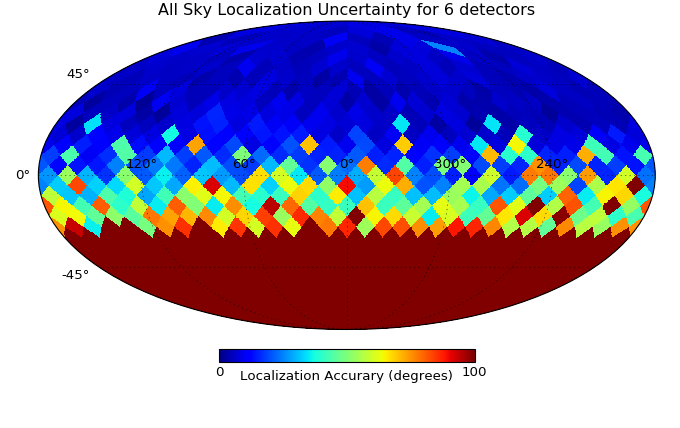

In [7]:

hp.newvisufunc.mollview(im,min=0, max=100,unit='Localization Accurary (degrees)',graticule=True,graticule_labels=True)
#plt.axes(projection='mollweide')

plt.title('All Sky Localization Uncertainty for 6 detectors')